In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
import sqlite3
import pandas as pd

# Specify the path to your .db file
db_path = 'data/database.db'

# Connect to the database
conn = sqlite3.connect(db_path)

# Get a list of all tables in the database (optional)
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)
print("Tables in the database:")
print(tables)

# Load data from a specific table into a pandas DataFrame
table_name = 'ASTEROIDS'  # Replace with the actual table name
df3 = pd.read_sql(f"SELECT * FROM {table_name};", conn)

# Close the connection
conn.close()

# Display the DataFrame
print(df3)

Tables in the database:
          name
0        FLEET
1      ROCKETS
2  SPACECRAFTS
3    ASTEROIDS
       Spkid    Surname     Name  OCC  Diameter    TOF          Launch_date  \
0    2000433    1898 DQ     Eros    0    16.840  270.0  2025-08-13 00:00:00   
1    2000719    1911 MT   Albert    0     4.390  180.0  2048-04-22 00:00:00   
2    2000887    1918 DB   Alinda    0     4.200  420.0  2025-01-01 00:00:00   
3    2001036    1924 TD  Ganymed    0    37.675  160.0  2037-05-18 00:00:00   
4    2001580    1950 KA  Betulia    0     5.800  440.0  2027-12-09 00:00:00   
..       ...        ...      ...  ...       ...    ...                  ...   
321  3114075   2002 DO3     None    6     0.230  310.0  2039-07-17 00:00:00   
322  3114077   2002 DQ3     None    6     0.100  380.0  2032-06-13 00:00:00   
323  3114105    2002 EA     None    8     0.180  120.0  2030-09-02 00:00:00   
324  3114106    2002 EC     None    7     0.120  430.0  2042-09-29 00:00:00   
325  3448992  2009 DD45     None

In [2]:
dtype_dict = {
    'spec_B': str,
    'spec_T': str,
    'spkid': str,
    'full_name': str,
    'name': str
    # Add other column mappings as necessary
}
df1 = pd.read_csv("data/spec.csv", dtype=dtype_dict)
len(df1)
df1 = df1[df1['spec_T'].notna()]
df1 = df1.drop(['spec_B', 'name', 'full_name'], axis=1)
df1 = df1[df1["spkid"].notna()]

In [3]:
df1["spkid"] = df1["spkid"].apply(lambda x: x.replace("0", "", 1))

In [4]:
dtype_dict = {
    'pdes': str,
    'name': str,
    'prefix': str,
    'neo': str,
    'spkid': str
}
df2 = pd.read_csv("data/ast_info.csv", dtype = dtype_dict)
ids = df2['spkid']
len(df2)
df2 = df2.drop(["id", "full_name", "pdes", "prefix", 'name'], axis=1)
df2 = df2[df2["spkid"].notna()]
df2['neo'] = df2['neo'].replace({'Y': 1, 'N': 0})

In [5]:
merged_df = pd.merge(df1, df2, on='spkid', how='right')

In [6]:
len(merged_df)

958524

In [7]:
useful_columns = [
    'H',           # Absolute Magnitude
    'albedo',      # Reflectivity
    'diameter',    # Object Diameter
    'i',           # Inclination
    'a',           # Semi-major Axis
    'q',           # Perihelion Distance
    'e',           # Eccentricity
    'neo',         # Near-Earth Object Flag
    'spec_T'         
]

# Filter the DataFrame to keep only the useful columns
merged_df = merged_df[useful_columns]

In [8]:
# asteroid_data = {
#     "composition": ['G', 'B', 'S', 'V', 'C', 'M', 'E', 'FC', 'P', 'CG', 'X', 'CU', 
#        'CF', 'XC', 'CP', 'BU', 'TDG', 'MU', 'T', 'GC', 'DCX', 'ST', 'CX',
#        'SU', 'SR', 'CPF', 'F', 'GU', 'I', 'XFC', 'STU', 'CD', 'GC:', 'C:',
#        'XC:', 'DCX:', 'BCU', 'A', 'SCTU', 'CX:', 'DU', 'PC', 'D', 'BFU::',
#        'CXF', 'FP', 'CSGU', 'R', 'DP', 'QSV', 'BFC', 'PD', 'DT', 'DX',
#        'F:', 'X:', 'TD', 'CSU', 'CB', 'FCX', 'FXU:', 'CGU', 'DU:', 'XD:',
#        'XCU', 'CDX:', 'CFB:', 'XDC', 'PCD', 'TSD', 'FCX:', 'XB:', 'SD',
#        'CD:', 'CP:', 'DX:', 'STGD', 'CGSU', 'FX:', 'XF', 'SC', 'CPU:',
#        'XD', 'DXCU', 'XFU', 'GS:', 'CBU:', 'CTGU:', 'FCB', 'XB', 'DTU',
#        'CB:', 'FC:', 'FU', 'PF', 'CFU:', 'XSC', 'DTU:', 'CGTP:', 'FCU',
#        'MU:', 'PDC', 'BC:', 'FX', 'XU', 'BCF', 'P:', 'PU', 'XSCU', 'AS',
#        'G:', 'CBU', 'FBCU::', 'AU:', 'XFCU', 'Q', 'SQ', 'SMU', 'BU:',
#        'TCG:', 'DSU:', 'CFXU', 'SG', 'BCU:', 'EU', 'SDU::', 'BFX', 'QRS',
#        'TS', 'Z']
# }

# Define mapping for each type
other_types = {'C', 'G', 'B', 'F', 'P', 'D', 'G:', 'C:', 'CG', 'CGU', 'CB', 'CB:', 'FC', 'FC:', 'BC', 'BC:', 'CP', 'CPF', 'PC', 'DCX', 'CD', 'CDX:', 'FCU', 'FCB', 'S', 'SU', 'SR', 'SQ', 'ST', 'SC', 'SCU', 'CSU', 'SD', 'SDU::', 'TS', 'STU', 'SCTU', 'AS'}
m_types = {'M', 'MU', 'MU:', 'E', 'X', 'XF', 'XFC', 'XCU', 'XU', 'XSC', 'XSCU'}

# Function to map composition to spec_T
def map_spec_type(comp):
    if comp in other_types:
        return 'Other'
    elif comp in m_types:
        return 'M'
    else:
        return None

# Apply the mapping
merged_df["spec_T"] = merged_df["spec_T"].apply(map_spec_type)

# Filter out rows where spec_T is None (i.e., mixed or unmapped types)
merged_df = merged_df.dropna()

In [9]:
len(merged_df)

778

In [10]:
X = merged_df.drop(["spec_T"], axis=1)
y = merged_df["spec_T"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [11]:
len(X_train)

521

In [12]:
smote = SMOTE(sampling_strategy={'Other': max(Counter(y_train).values()),
                                 'M': max(Counter(y_train).values())},
              random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler

train_neo = X_train["neo"]
test_neo = X_test["neo"]

# Drop the "neo" column for scaling
train_features = X_train.drop(columns=["neo"])
test_features = X_test.drop(columns=["neo"])

# Apply Standard Scaling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

# Convert back to DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_features.columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_features.columns)

# Add the "neo" column back
X_train["neo"] = train_neo.values
X_test["neo"] = test_neo.values

In [14]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [15]:
mapping = {'M': 0, 'Other': 1}
y_train_mapped = y_train.map(mapping)
y_test_mapped = y_test.map(mapping)

In [96]:
xgb_model = XGBClassifier()

#Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5),
    'gamma': [0, 0.1, 0.2, 0.3],
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='accuracy',  # Scoring metric
    cv=10,  # Cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train_mapped)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


<Axes: >

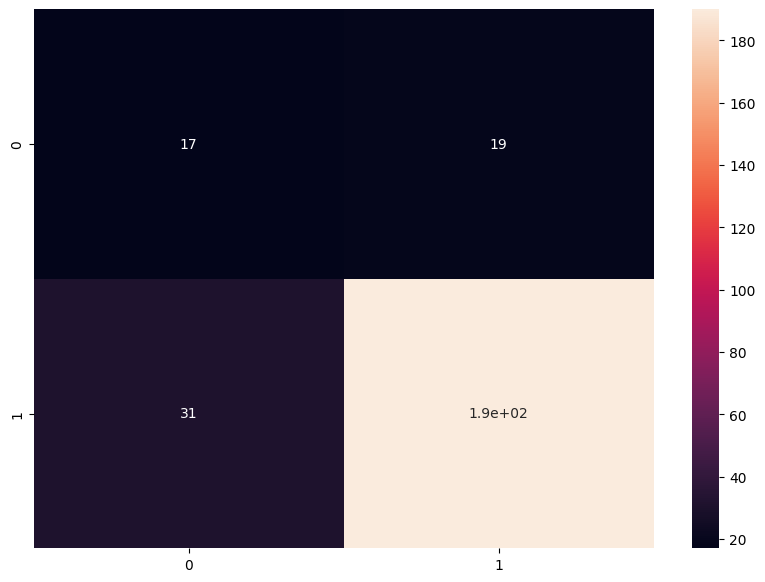

In [97]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
cm = confusion_matrix(y_test_mapped, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [17]:
xgb_model = XGBClassifier(objective="binary:logistic")

X = merged_df.drop(["spec_T"], axis=1)
y = merged_df["spec_T"]

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy={'Other': max(Counter(y).values()),
                                 'M': max(Counter(y).values())},
              random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

# Separate "neo" column for scaling the rest
neo_column = X_resampled["neo"].values  # Ensure neo is stored correctly

# Drop the "neo" column for scaling
features_to_scale = X_resampled.drop(columns=["neo"])

# Apply Standard Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_to_scale)

# Convert back to DataFrame
features_scaled_df = pd.DataFrame(features_scaled, columns=features_to_scale.columns)

# Add the "neo" column back
features_scaled_df["neo"] = neo_column

# Update X with the scaled features
X = features_scaled_df

y = y_resampled

mapping = {'M': 0, 'Other': 1}
y = y.map(mapping)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5),
    'gamma': [0, 0.1, 0.2, 0.3],
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',  # Scoring metric
    cv=10,  # Cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X, y)
best_model = random_search.best_estimator_
import pickle
with open('model2.pkl', 'wb') as file:
    pickle.dump(best_model, file)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [45]:
dtype_dict = {
    'spec_B': str,
    'spec_T': str,
    'spkid': str,
    'full_name': str,
    'name': str
    # Add other column mappings as necessary
}
df1 = pd.read_csv("data/spec.csv", dtype=dtype_dict)
len(df1)
df1 = df1[df1['spec_T'].notna()]
df1 = df1.drop(['spec_B', 'name', 'full_name'], axis=1)
df1 = df1[df1["spkid"].notna()]

df1["spkid"] = df1["spkid"].apply(lambda x: x.replace("0", "", 1))

dtype_dict = {
    'pdes': str,
    'name': str,
    'prefix': str,
    'neo': str,
    'spkid': str
}
df2 = pd.read_csv("data/ast_info.csv", dtype = dtype_dict)
ids = df2['spkid']
len(df2)
df2 = df2.drop(["id", "full_name", "pdes", "prefix", 'name'], axis=1)
df2 = df2[df2["spkid"].notna()]
df2['neo'] = df2['neo'].replace({'Y': 1, 'N': 0})

merged_df = pd.merge(df1, df2, on='spkid', how='right')

useful_columns = [
    'H',           # Absolute Magnitude
    'albedo',      # Reflectivity
    'diameter',    # Object Diameter
    'i',           # Inclination
    'a',           # Semi-major Axis
    'q',           # Perihelion Distance
    'e',           # Eccentricity
    'neo',         # Near-Earth Object Flag
    'spec_T'         
]

# Filter the DataFrame to keep only the useful columns
merged_df = merged_df[useful_columns]

other_types = {'C', 'G', 'B', 'F', 'P', 'D', 'G:', 'C:', 'CG', 'CGU', 'CB', 'CB:', 'FC', 'FC:', 'BC', 'BC:', 'CP', 'CPF', 'PC', 'DCX', 'CD', 'CDX:', 'FCU', 'FCB', 'S', 'SU', 'SR', 'SQ', 'ST', 'SC', 'SCU', 'CSU', 'SD', 'SDU::', 'TS', 'STU', 'SCTU', 'AS'}
m_types = {'M', 'MU', 'MU:', 'E', 'X', 'XF', 'XFC', 'XCU', 'XU', 'XSC', 'XSCU'}

# Function to map composition to spec_T
def map_spec_type(comp):
    if comp in other_types:
        return 'Other'
    elif comp in m_types:
        return 'M'
    else:
        return None

# Apply the mapping
merged_df["spec_T"] = merged_df["spec_T"].apply(map_spec_type)

In [46]:
import pickle
with open('model2.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
filled_mask = merged_df['spec_T'].notna()
not_filled_mask = ~filled_mask
df_filled = merged_df[filled_mask]
df_not_filled = merged_df[not_filled_mask]
X_missing = df_not_filled.drop(['spec_T'], axis=1)
predictions = loaded_model.predict_proba(X_missing)
merged_df.loc[not_filled_mask, 'spec_T'] = predictions[:,0]
merged_df["spkid"] = ids
merged_df2 = merged_df

In [48]:
merged_df2

,H,albedo,diameter,i,a,q,e,neo,spec_T,spkid
0,3.400,0.0900,939.400,10.594067,2.769165,2.558684,0.076009,0.0,Other,2000001
1,4.200,0.1010,545.000,34.832932,2.773841,2.135935,0.229972,0.0,Other,2000002
2,5.330,0.2140,246.596,12.991043,2.668285,1.982706,0.256936,0.0,Other,2000003
3,3.000,0.4228,525.400,7.141771,2.361418,2.151909,0.088721,0.0,0.017146,2000004
4,6.900,0.2740,106.699,5.367427,2.574037,2.082619,0.190913,0.0,Other,2000005
...,...,...,...,...,...,...,...,...,...,...
958519,17.135,NaN,NaN,5.984416,2.280861,1.856807,0.185919,0.0,0.649637,3246801
958520,18.500,NaN,NaN,8.082280,2.334910,1.674319,0.282920,0.0,0.790366,3246834
958521,20.400,NaN,NaN,4.679278,2.817152,0.950941,0.662446,1.0,0.888647,3013075
958522,18.071,NaN,NaN,0.732484,2.373137,1.893638,0.202053,0.0,0.91701,3246457


In [23]:
len(predictions)

957732

In [24]:
len(merged_df)

958524

In [ ]:
df = 

In [63]:
merged_df.isna().sum()/len(merged_df)*100

H            0.653400
albedo      85.905100
diameter    85.789714
i            0.000000
a            0.000000
q            0.000000
e            0.000000
neo          0.000417
spec_T      99.897759
dtype: float64

In [64]:
merged_df.head()

,H,albedo,diameter,i,a,q,e,neo,spec_T
0,3.40,0.0900,939.400,10.594067,2.769165,2.558684,0.076009,0.0,G
1,4.20,0.1010,545.000,34.832932,2.773841,2.135935,0.229972,0.0,B
2,5.33,0.2140,246.596,12.991043,2.668285,1.982706,0.256936,0.0,S
3,3.00,0.4228,525.400,7.141771,2.361418,2.151909,0.088721,0.0,V
4,6.90,0.2740,106.699,5.367427,2.574037,2.082619,0.190913,0.0,S


In [65]:
filled_mask = merged_df['spec_T'].notna()
not_filled_mask = ~filled_mask

In [68]:
df_filled = merged_df[filled_mask]
df_not_filled = merged_df[not_filled_mask]